# Alphalens - Open Source Factor Analysis

In [1]:
import numpy as np
import pandas as pd
import alphalens
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import CustomFactor, Latest, Returns, RSI, EWMA as ewma, SimpleMovingAverage
from quantopian.pipeline.filters import Q1500US
from quantopian.pipeline.classifiers.fundamentals import Sector
import scipy.stats as st

## Define the Factors

In [2]:
class pe_ratio(CustomFactor):
    window_length = 1
    inputs = [Fundamentals.pe_ratio]
    def compute(self, today, assets, out, pe_ratio):
        out[:] = np.where(pe_ratio <= 0, 0, 1/pe_ratio)

class ev_ebitda(CustomFactor):
    window_length = 1
    inputs = [Fundamentals.ev_to_ebitda]
    def compute(self, today, assets, out, ev_to_ebitda):
        out[:] = np.where(ev_to_ebitda <= 0, 0, 1/ev_to_ebitda)

## Set Universe

In [3]:
universe = Q1500US()

## Create the Pipeline

In [4]:
pipe = Pipeline(
    columns={
        'pe_ratio': pe_ratio(mask=universe),
        'ev_ebitda': ev_ebitda(mask=universe),
    },
    screen=universe
)

## Run the Pipeline

In [5]:
results = run_pipeline(pipe, '2011-12-31', '2018-01-15')

In [6]:
results.head()


ev_ebitda  pe_ratio
2012-01-03 00:00:00+00:00 Equity(2 [ARNC])    0.089852    0.0636
                          Equity(24 [AAPL])   0.124653    0.0868
                          Equity(62 [ABT])    0.176985    0.0537
                          Equity(67 [ADSK])   0.080647    0.0387
                          Equity(76 [TAP])    0.127293    0.0831

## Get pricing

In [7]:
assets = results.index.levels[1].unique()
# Make sure to extend the pricing a bit to get a full set of returns.
pricing = get_pricing(assets, start_date='2011-12-31', end_date='2018-01-15', fields='open_price')

In [8]:
results.head()

ev_ebitda  pe_ratio
2012-01-03 00:00:00+00:00 Equity(2 [ARNC])    0.089852    0.0636
                          Equity(24 [AAPL])   0.124653    0.0868
                          Equity(62 [ABT])    0.176985    0.0537
                          Equity(67 [ADSK])   0.080647    0.0387
                          Equity(76 [TAP])    0.127293    0.0831

##Build Tearsheet

AlphaLens builds a single factor tearsheet. 

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000100,0.031300,0.011683,0.007186,410521,20.046997
2,0.019263,0.050700,0.032246,0.006381,409659,20.004903
3,0.033934,0.065500,0.046341,0.006138,409065,19.975896
4,0.045651,0.088600,0.061028,0.008033,409052,19.975261
5,0.062000,87.912088,0.147725,0.867916,409496,19.996943


Returns Analysis


,5,20,70
Ann. alpha,-0.059,-0.045,-0.053
beta,0.132,0.059,0.055
Mean Period Wise Return Top Quantile (bps),1.195,1.555,-17.900
Mean Period Wise Return Bottom Quantile (bps),-3.311,-11.532,-18.776
Mean Period Wise Spread (bps),0.852,0.617,-0.032


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=20).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/pl

Information Analysis


,5,20,70
IC Mean,0.004,0.006,0.005
IC Std.,0.094,0.098,0.098
t-stat(IC),1.654,2.239,1.746
p-value(IC),0.098,0.025,0.081
IC Skew,0.256,0.239,0.322
IC Kurtosis,0.112,-0.062,-0.012
Ann. IR,0.690,0.934,0.728


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:215: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(ic, 22).plot(ax=a,


Turnover Analysis


,5,20,70
Quantile 1 Mean Turnover,0.027,0.084,0.209
Quantile 2 Mean Turnover,0.056,0.162,0.345
Quantile 3 Mean Turnover,0.075,0.205,0.391
Quantile 4 Mean Turnover,0.071,0.195,0.373
Quantile 5 Mean Turnover,0.035,0.101,0.223


,5,20,70
Mean Factor Rank Autocorrelation,0.992,0.967,0.892


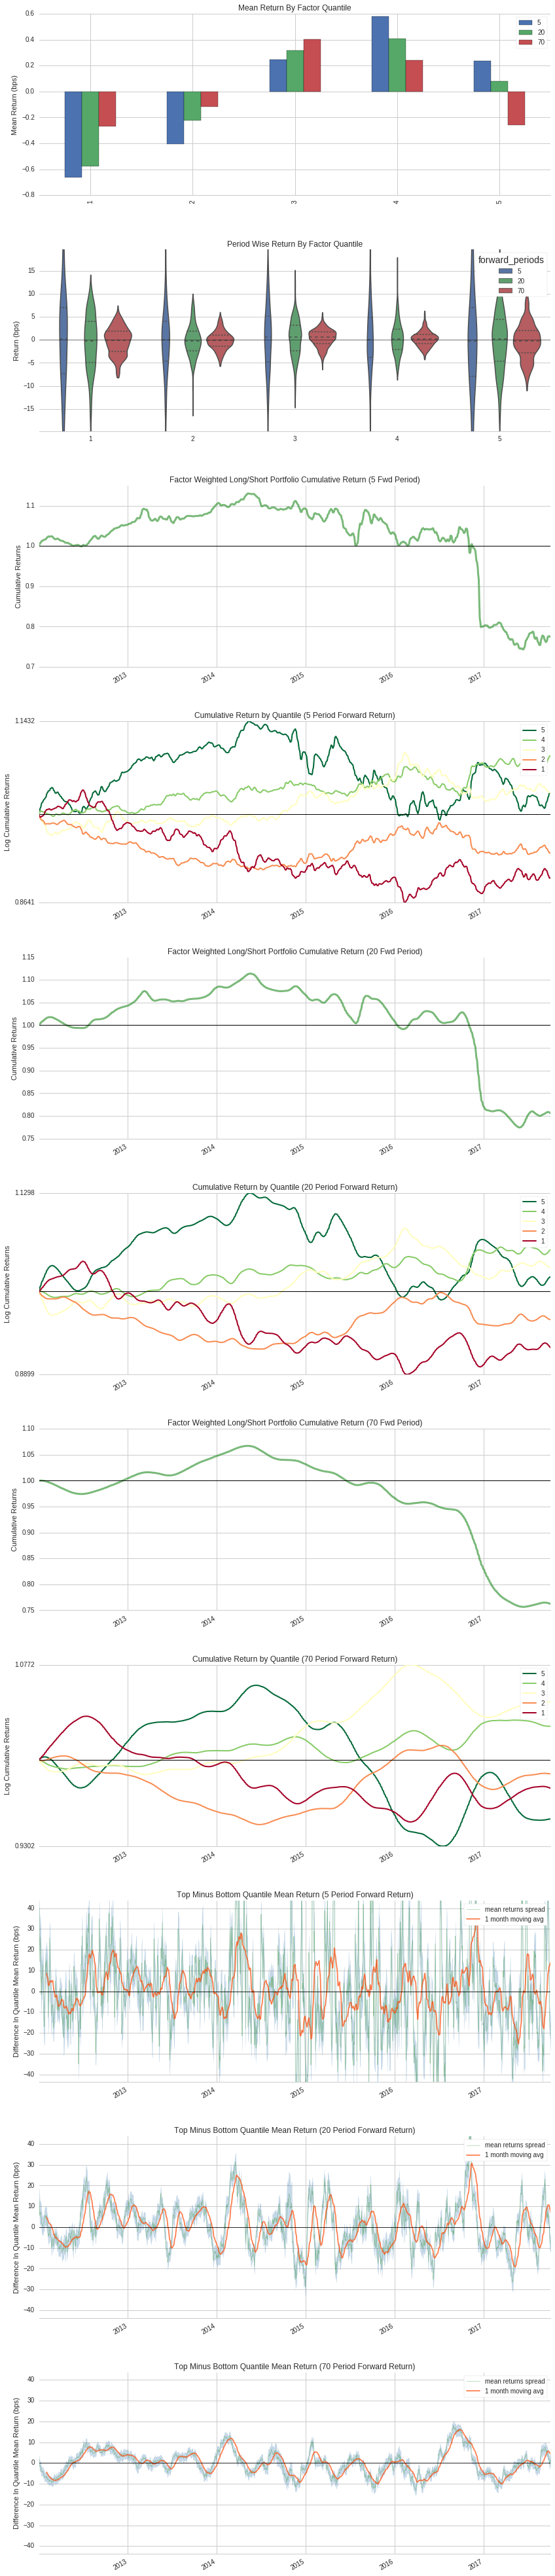

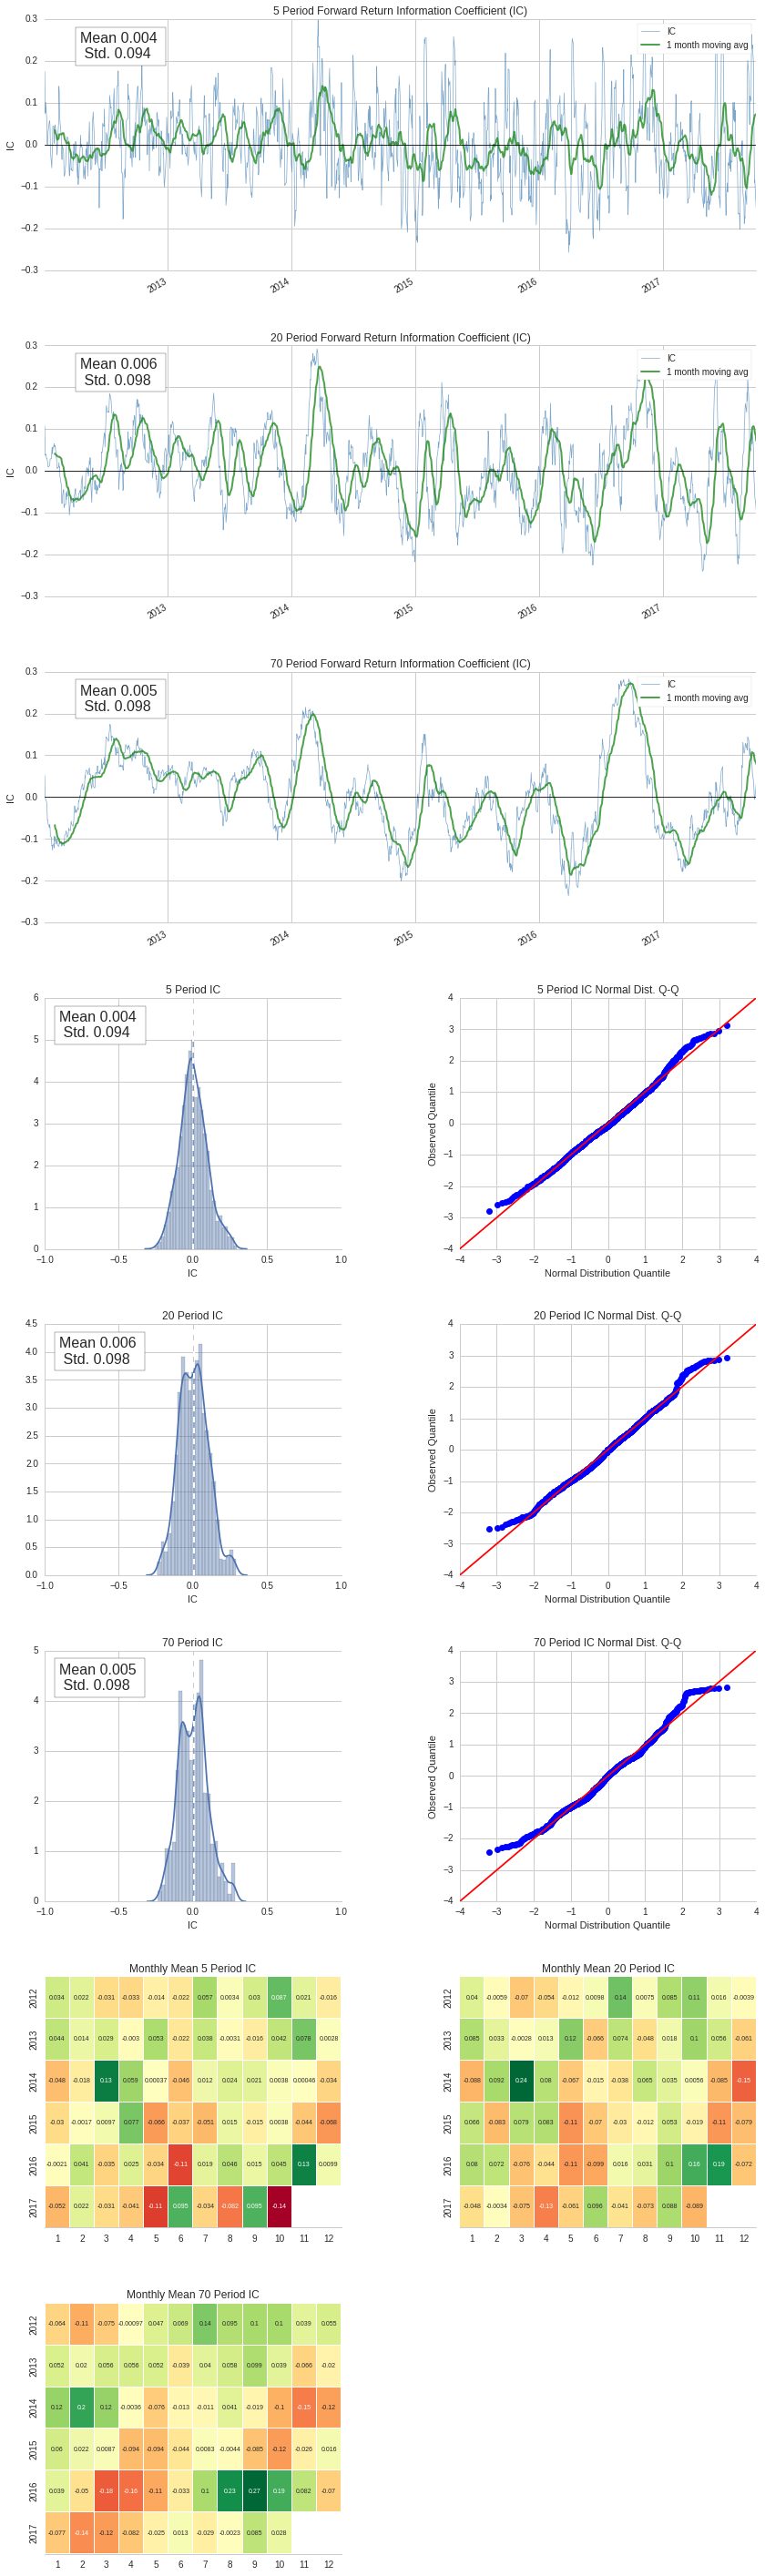

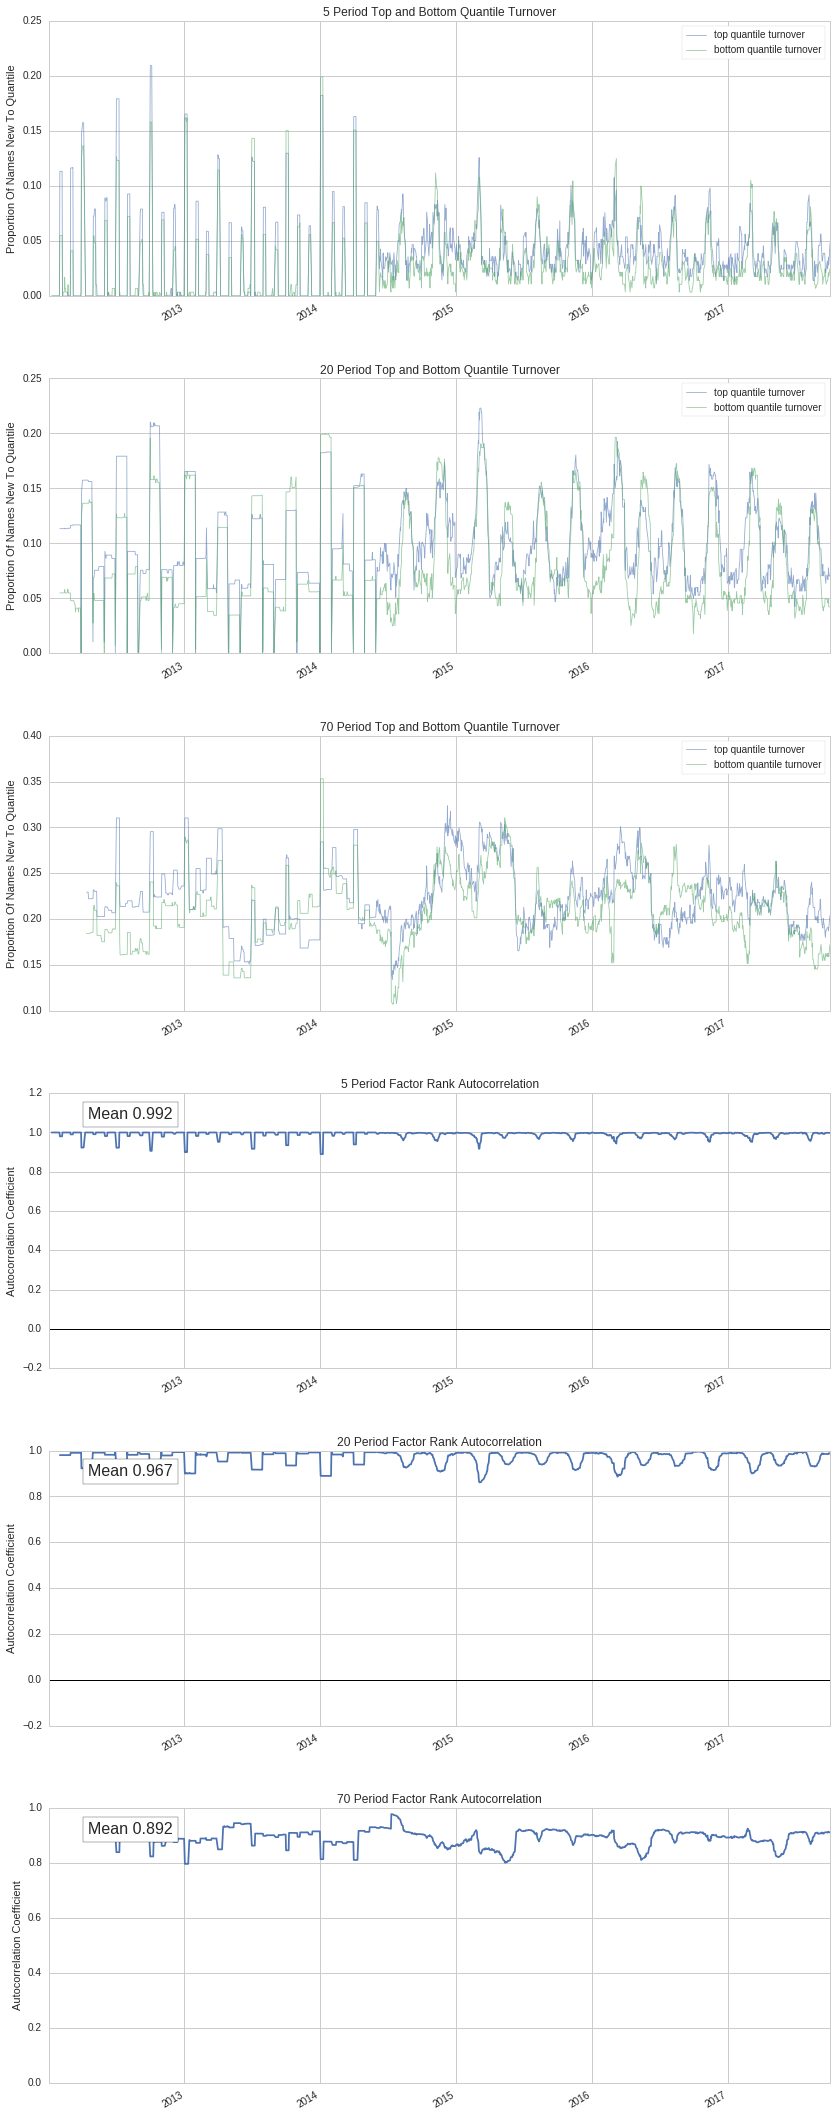

In [9]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(results['pe_ratio'],
                                                                   pricing,
                                                                   quantiles=5,
                                                                   periods=(5,20,70))

alphalens.tears.create_full_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000000,0.056677,0.018043,0.017120,426363,20.025617
2,0.024247,0.091866,0.059557,0.009621,425541,19.987009
3,0.045402,0.117915,0.081689,0.010515,425545,19.987196
4,0.060269,0.156703,0.106008,0.014091,425527,19.986351
5,0.079902,2500.000000,0.286659,8.941346,426112,20.013828


Returns Analysis


,5,20,70
Ann. alpha,0.038,0.044,0.032
beta,-0.042,-0.055,-0.004
Mean Period Wise Return Top Quantile (bps),1.521,1.290,-6.798
Mean Period Wise Return Bottom Quantile (bps),-5.293,-20.370,-57.234
Mean Period Wise Spread (bps),1.399,1.143,0.782


Information Analysis


,5,20,70
IC Mean,0.007,0.011,0.023
IC Std.,0.108,0.117,0.120
t-stat(IC),2.439,3.516,7.171
p-value(IC),0.015,0.000,0.000
IC Skew,0.200,0.418,0.368
IC Kurtosis,0.118,-0.281,-0.302
Ann. IR,1.017,1.467,2.991


Turnover Analysis


,5,20,70
Quantile 1 Mean Turnover,0.029,0.088,0.208
Quantile 2 Mean Turnover,0.058,0.162,0.326
Quantile 3 Mean Turnover,0.076,0.209,0.389
Quantile 4 Mean Turnover,0.072,0.195,0.367
Quantile 5 Mean Turnover,0.036,0.101,0.211


,5,20,70
Mean Factor Rank Autocorrelation,0.992,0.97,0.906


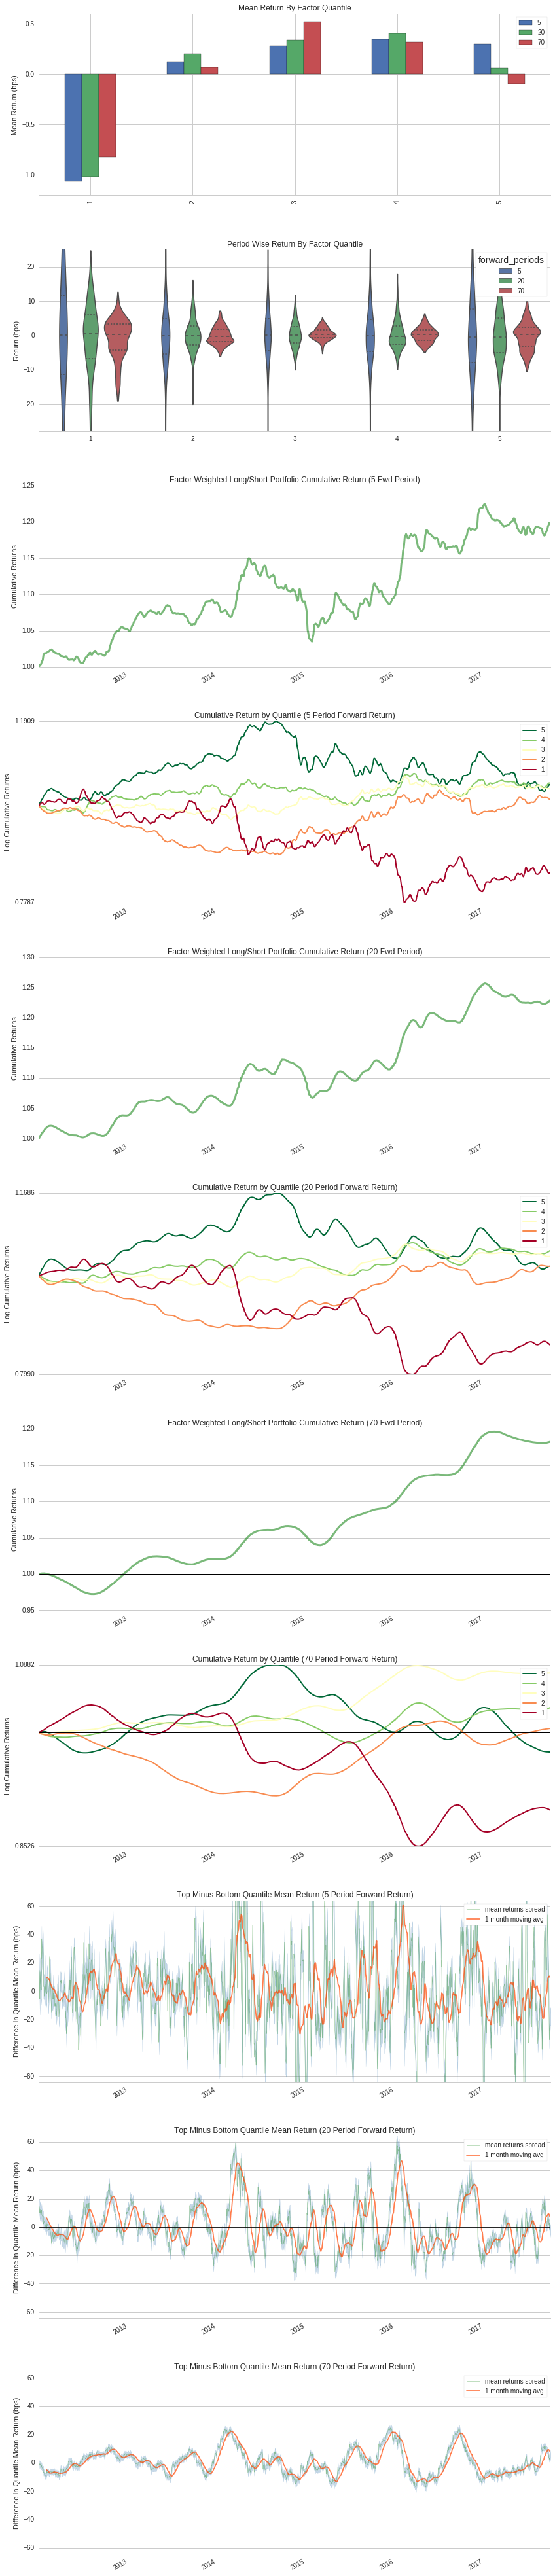

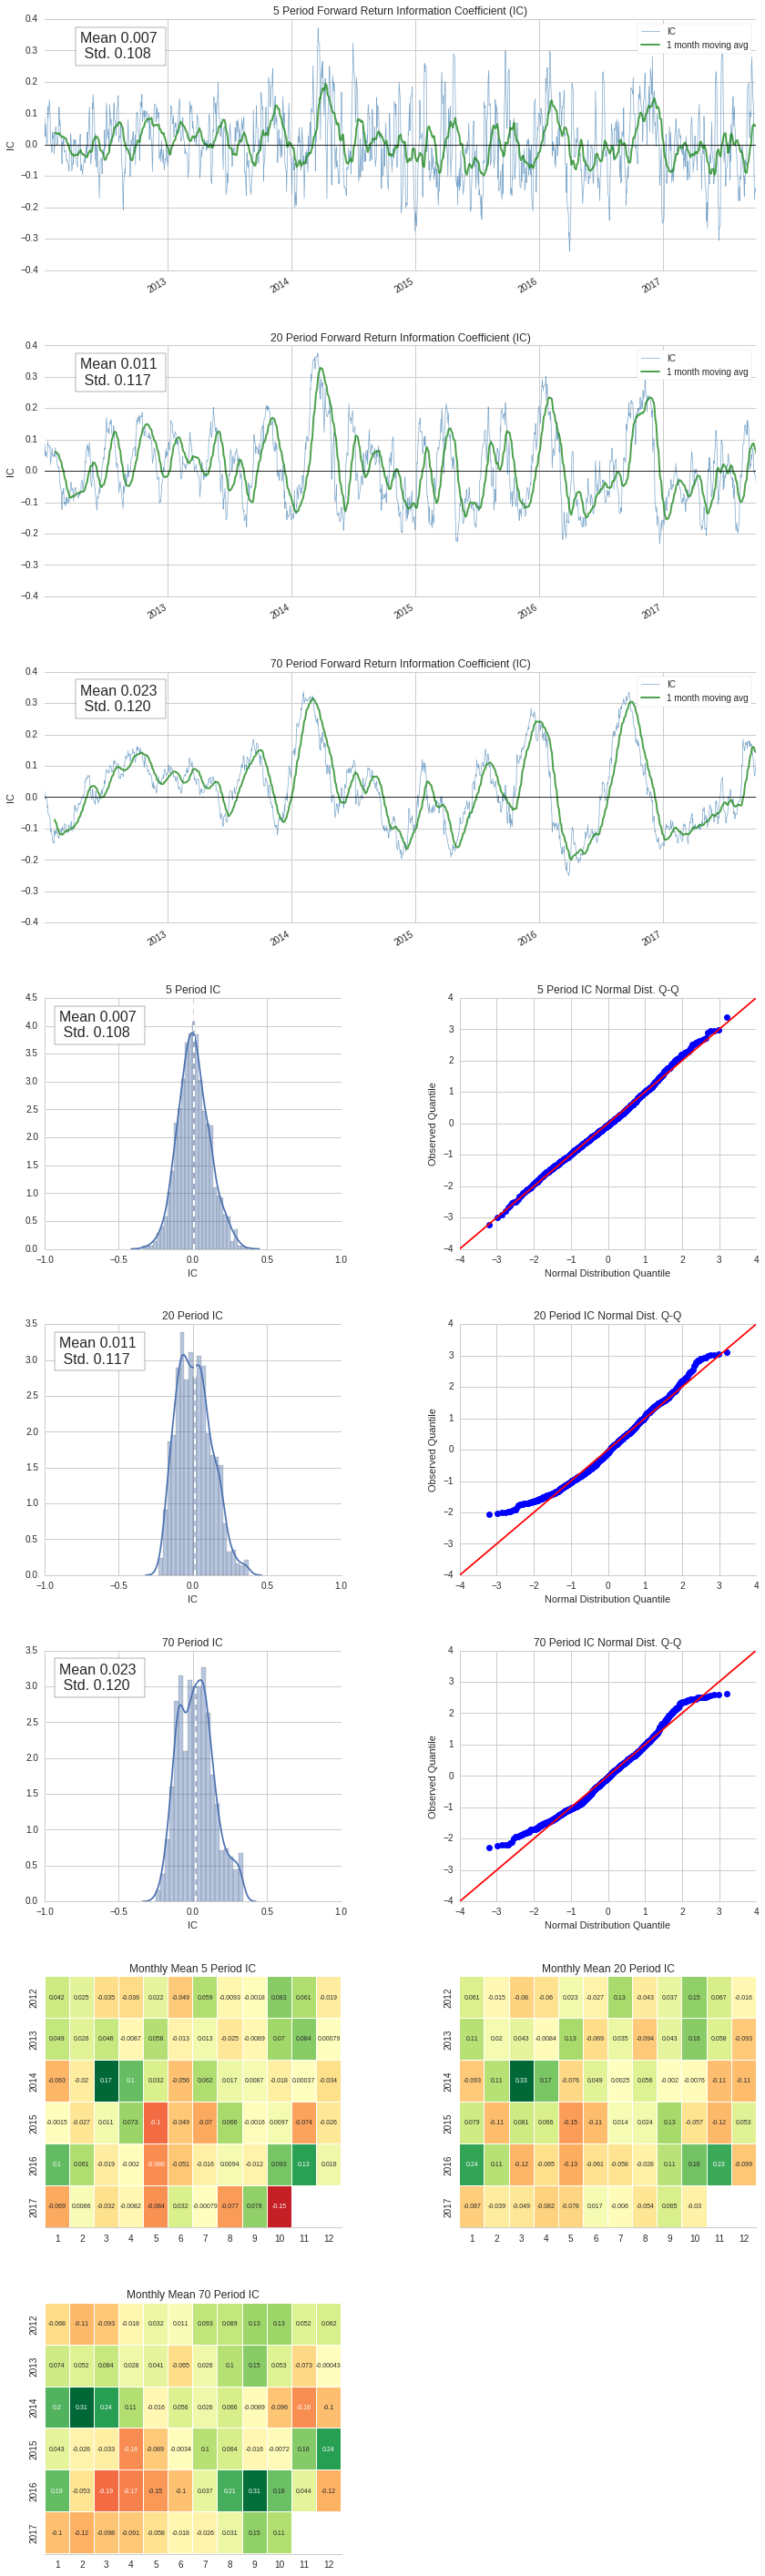

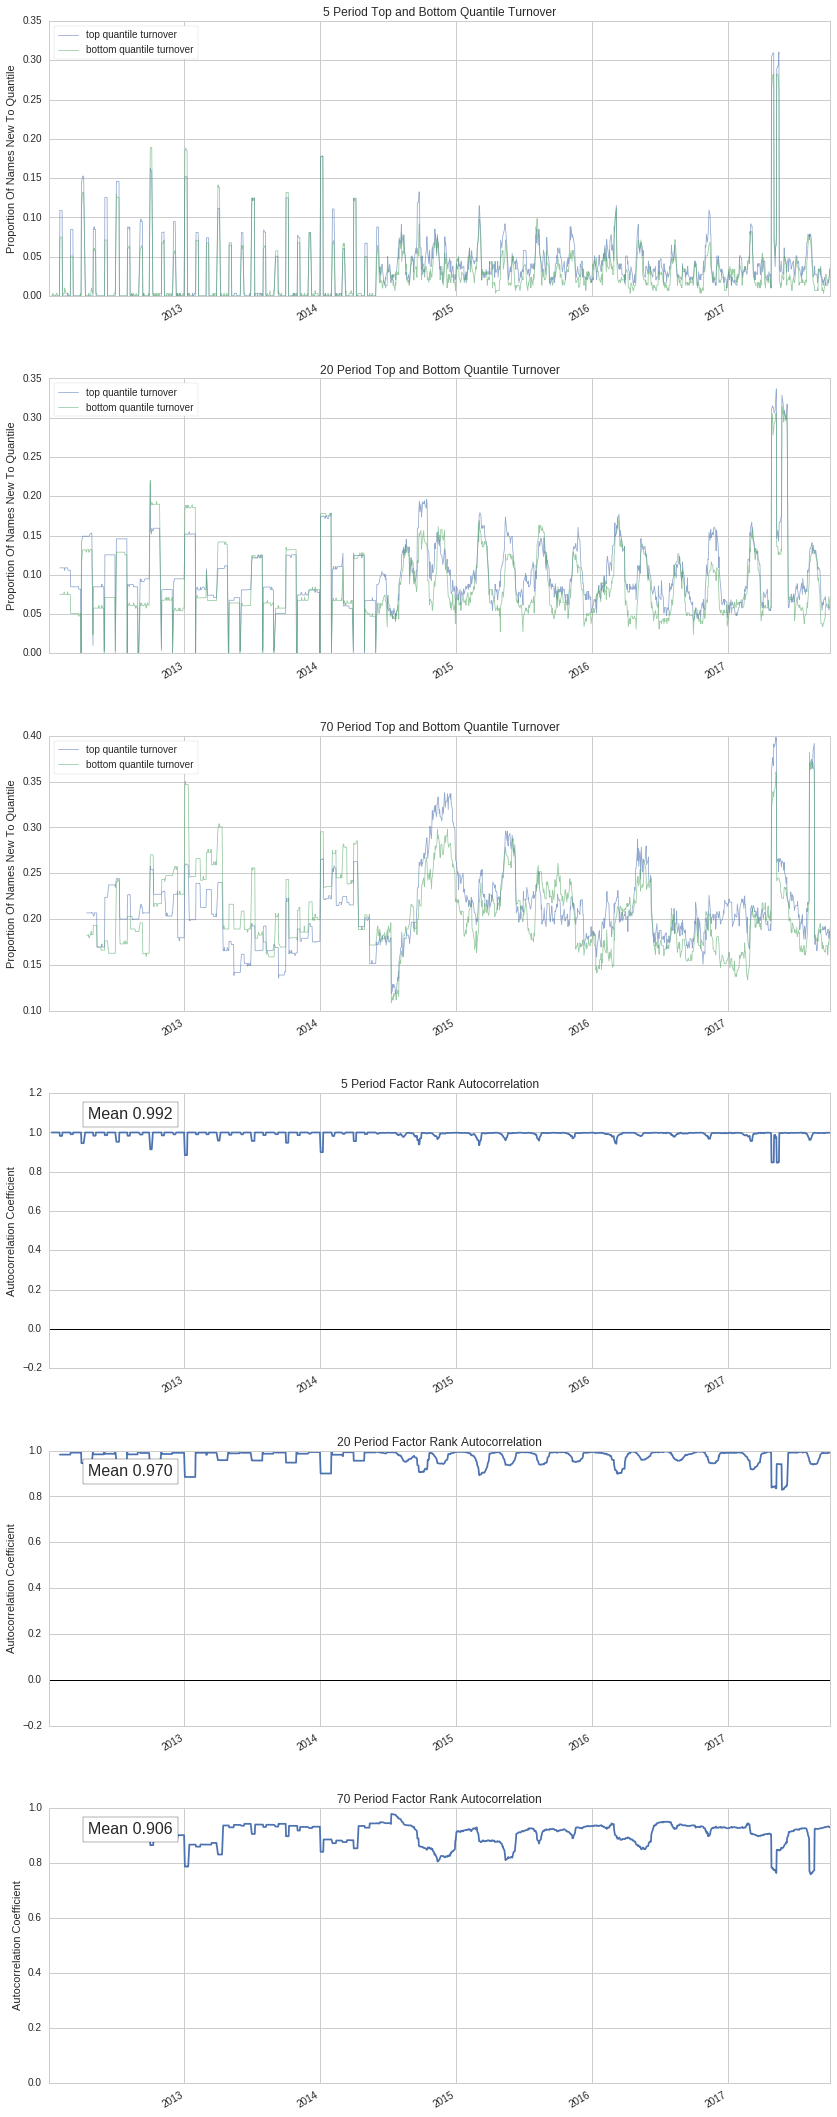

In [10]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(results['ev_ebitda'],
                                                                   pricing,
                                                                   quantiles=5,
                                                                   periods=(5,20,70))

alphalens.tears.create_full_tear_sheet(factor_data)